In [1]:
# get all libraries

import os.path as osp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
import time
import warnings

from sklearn import metrics
from sklearn.metrics import make_scorer,classification_report,confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc,accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, log_loss
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders import TargetEncoder

from hyperopt import hp, fmin, tpe,Trials
from IPython.display import HTML

import ydata_profiling
from yellowbrick.target import FeatureCorrelation
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.classifier import DiscriminationThreshold


D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
D:\Anaconda\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\adpur\AppData\Roaming\Python\Python38\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be change

the dataset has these features:
* Unit Number - The unique identifier for a Engine type
*  Cycle - Elapsed Cycle
*  3 operational Settings
*  21  Sensor Settings

In [2]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [3]:
# Read the training Dataset
data_path = osp.join(
  osp.curdir,'predictive-maintenance\\train_FD001.txt')
train_df = pd.read_csv(data_path,sep='\s+',header=None,index_col=False,names=col_names)
train_df.head(5)

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
# Read the validation/test Dataset
data_path = osp.join(
  osp.curdir,'predictive-maintenance\\test_FD001.txt')
valid_df = pd.read_csv(data_path,sep='\s+',header=None,index_col=False,names=col_names)
valid_df.head(5)

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [5]:
# Read the prediction values
data_path = osp.join(
  osp.curdir,'predictive-maintenance\\RUL_FD001.txt')
y_valid = pd.read_csv(data_path,sep='\s+',header=None,index_col=False,names=['RUL'])
y_valid.head(5)

,RUL
0,112
1,98
2,69
3,82
4,91


Calculating the Remaining Useful Life (RUL) is a key aspect when working with the NASA Turbo Fan Jet Engine dataset. The dataset usually consists of multiple engines, each identified by a unit number, and for each engine, we have multiple cycles. The last cycle for each engine usually signifies failure. The idea is to calculate the RUL for each cycle as a countdown to this last cycle.

In [6]:
# create a function to calculate RUL

def calculate_RUL(df):
    # Sort the DataFrame by 'unit_number' and 'time_in_cycles'
    df = df.sort_values(['unit_number', 'time_cycles'])
    
    # Calculate max cycle for each unit
    max_cycle_df  = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
    max_cycle_df .columns = ['unit_number', 'max_cycle']
    
    # Merge the max cycle back into the original dataframe
    df = df.merge(max_cycle_df, on='unit_number', how='left')
    
    # Calculate RUL for each row
    df['RUL'] = df['max_cycle'] - df['time_cycles']
    
    # Drop the max_cycle column
    df = df.drop('max_cycle', axis=1)
    return df

In [7]:
#Apply the function on the Train set
train_df= calculate_RUL(train_df)
train_df.head(10)

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,186
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774,185
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106,184
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066,183
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694,182


In [8]:
#examine the datatype of the train set
train_df.dtypes

unit_number      int64
time_cycles      int64
setting_1      float64
setting_2      float64
setting_3      float64
s_1            float64
s_2            float64
s_3            float64
s_4            float64
s_5            float64
s_6            float64
s_7            float64
s_8            float64
s_9            float64
s_10           float64
s_11           float64
s_12           float64
s_13           float64
s_14           float64
s_15           float64
s_16           float64
s_17             int64
s_18             int64
s_19           float64
s_20           float64
s_21           float64
RUL              int64
dtype: object

In [9]:
print(train_df.isnull().sum())

unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
RUL            0
dtype: int64


In [10]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit_number,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time_cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


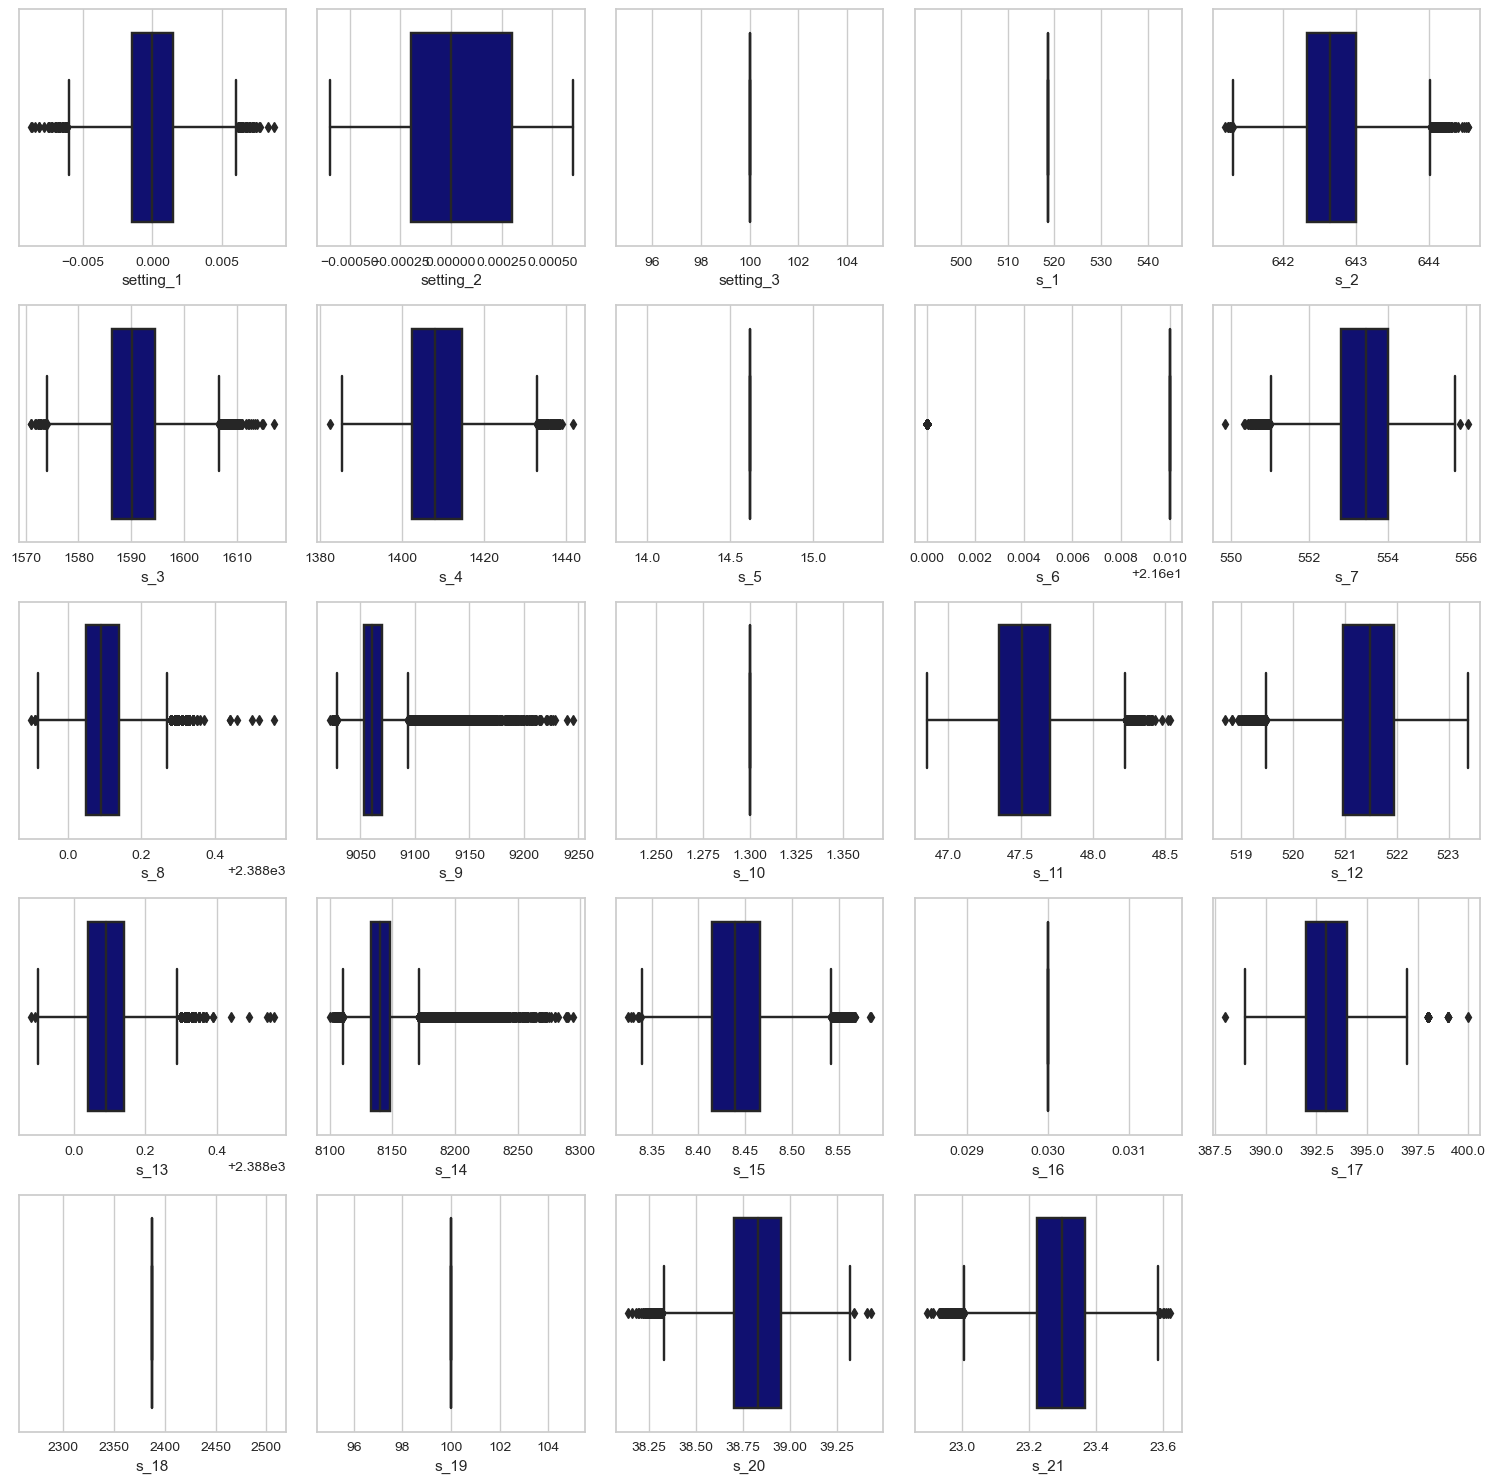

In [11]:
 # EDA for settings and sensors
numeric_cols = setting_names + sensor_names
num_plots = len(numeric_cols)
total_cols = 5
total_rows = num_plots // total_cols
total_rows += 1 if num_plots % total_cols > 0 else 0  # Add an extra row if there are remaining plots

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, 
                        figsize=(3 * total_cols, 3 * total_rows))

# Flatten the axs array to make it easier to index
axs = axs.flatten()

for i, var in enumerate(numeric_cols):
    sns.boxplot(x=var,data=train_df, ax=axs[i],color="navy")

# Remove unused subplots
for i in range(num_plots, total_cols * total_rows):
    fig.delaxes(axs[i])

fig.tight_layout()


<Axes: >

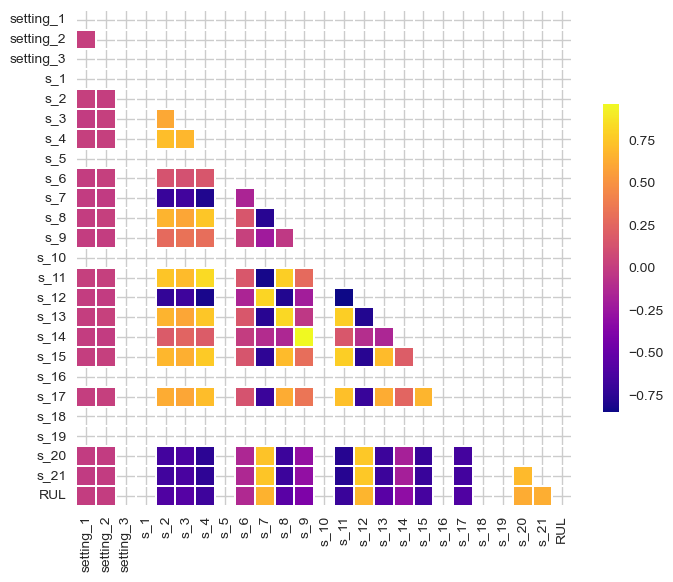

In [12]:
#examine correlations in the train DF
corr_cols = setting_names + sensor_names + ['RUL']
corr = train_df[corr_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='plasma', square=True, linewidths=.01, cbar_kws={"shrink": .5})

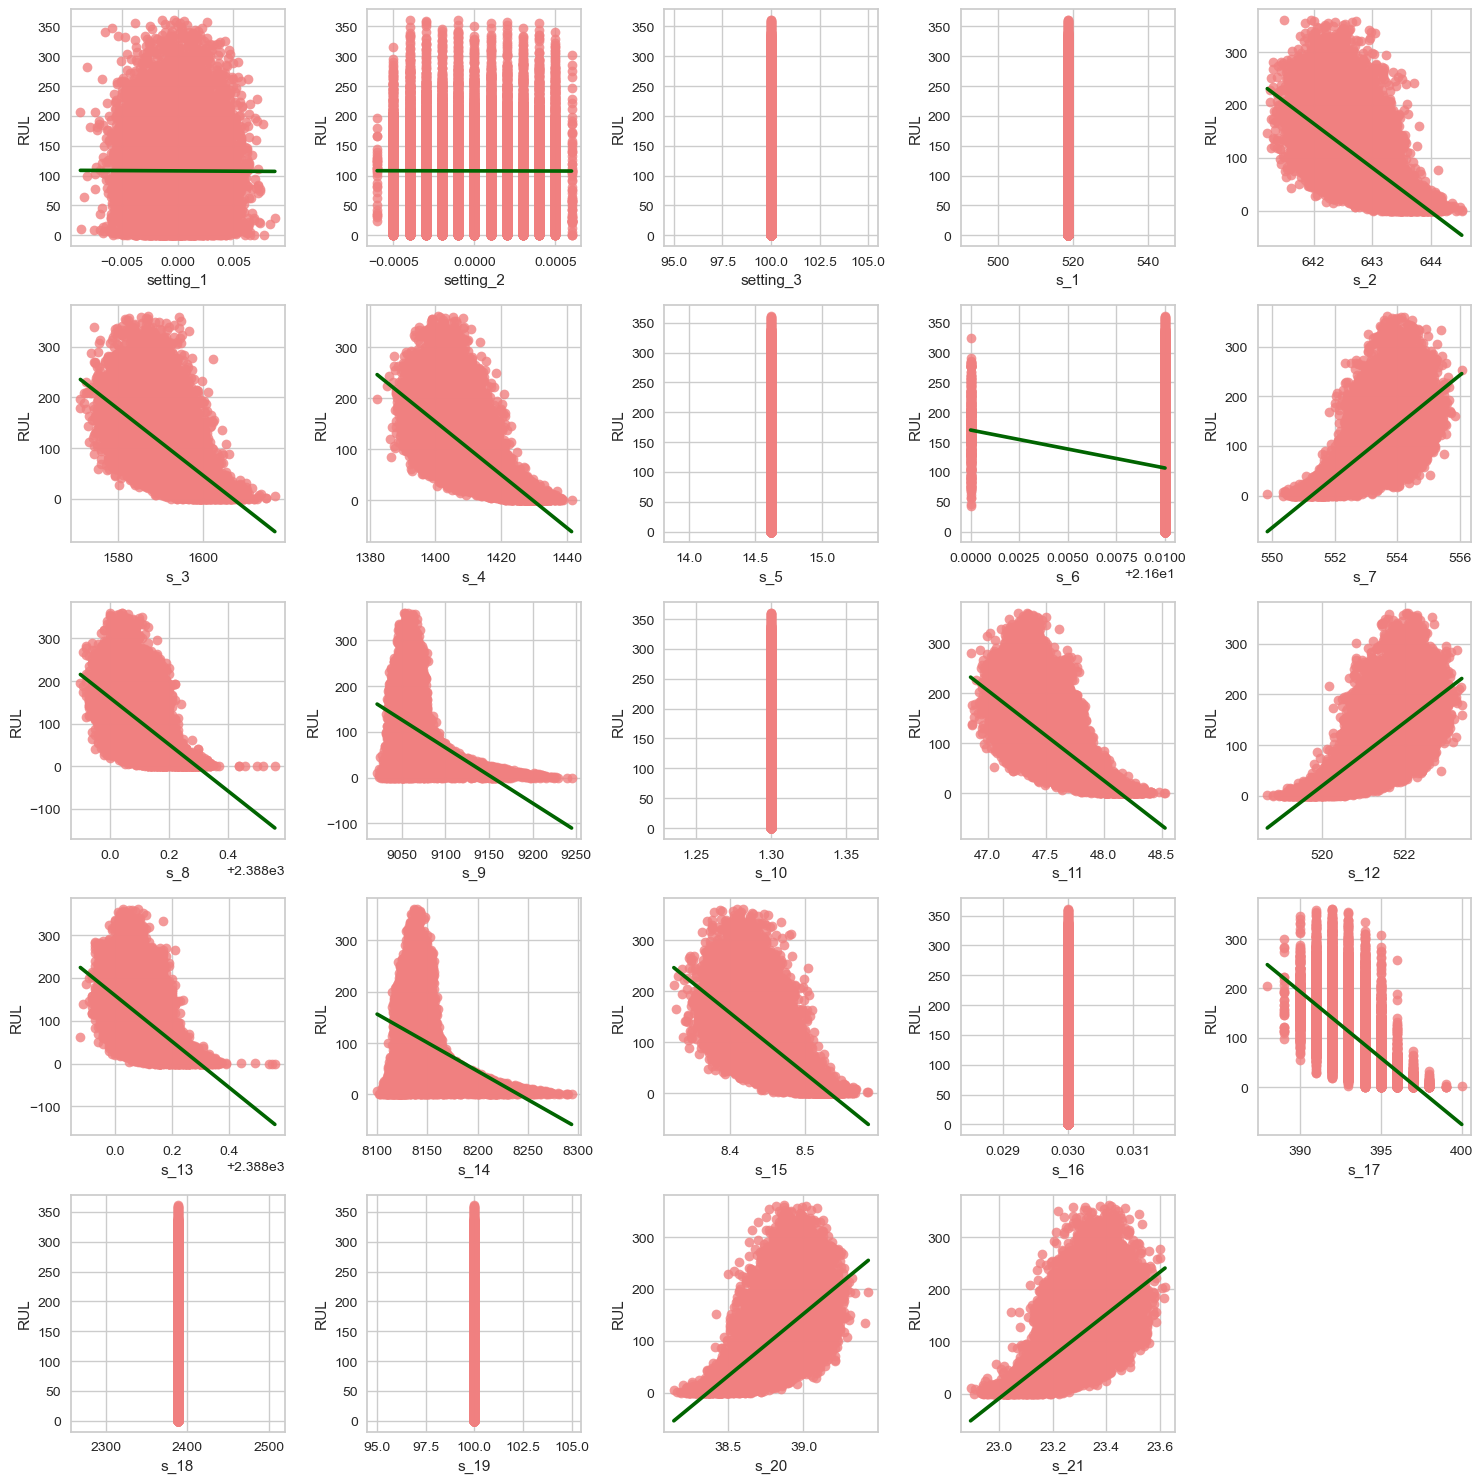

In [13]:
# Do some more EDA w.r.t. to the target

numeric_cols = setting_names + sensor_names
num_plots = len(numeric_cols)
total_cols = 5
total_rows = num_plots // total_cols
total_rows += 1 if num_plots % total_cols > 0 else 0  # Add an extra row if there are remaining plots

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, figsize=(3 * total_cols, 3 * total_rows))

# Flatten the axs array to make it easier to index
axs = axs.flatten()

for i, var in enumerate(numeric_cols):
    sns.regplot(x=var, y="RUL", data=train_df, ax=axs[i], ci=False, 
                line_kws={'color': 'darkgreen'},scatter_kws={'color': 'lightcoral'})

# Remove unused subplots
for i in range(num_plots, total_cols * total_rows):
    fig.delaxes(axs[i])

fig.tight_layout()


From the above plots, it appears as these sensor values may be constant values or without any correlation with RUL
* setting_1
* setting_2
* setting_3
* s_1
* s_5
* s_6
* s_10
* s_16
* s_18
* s_19

We can generate some histograms to confirm if our suspicions are true

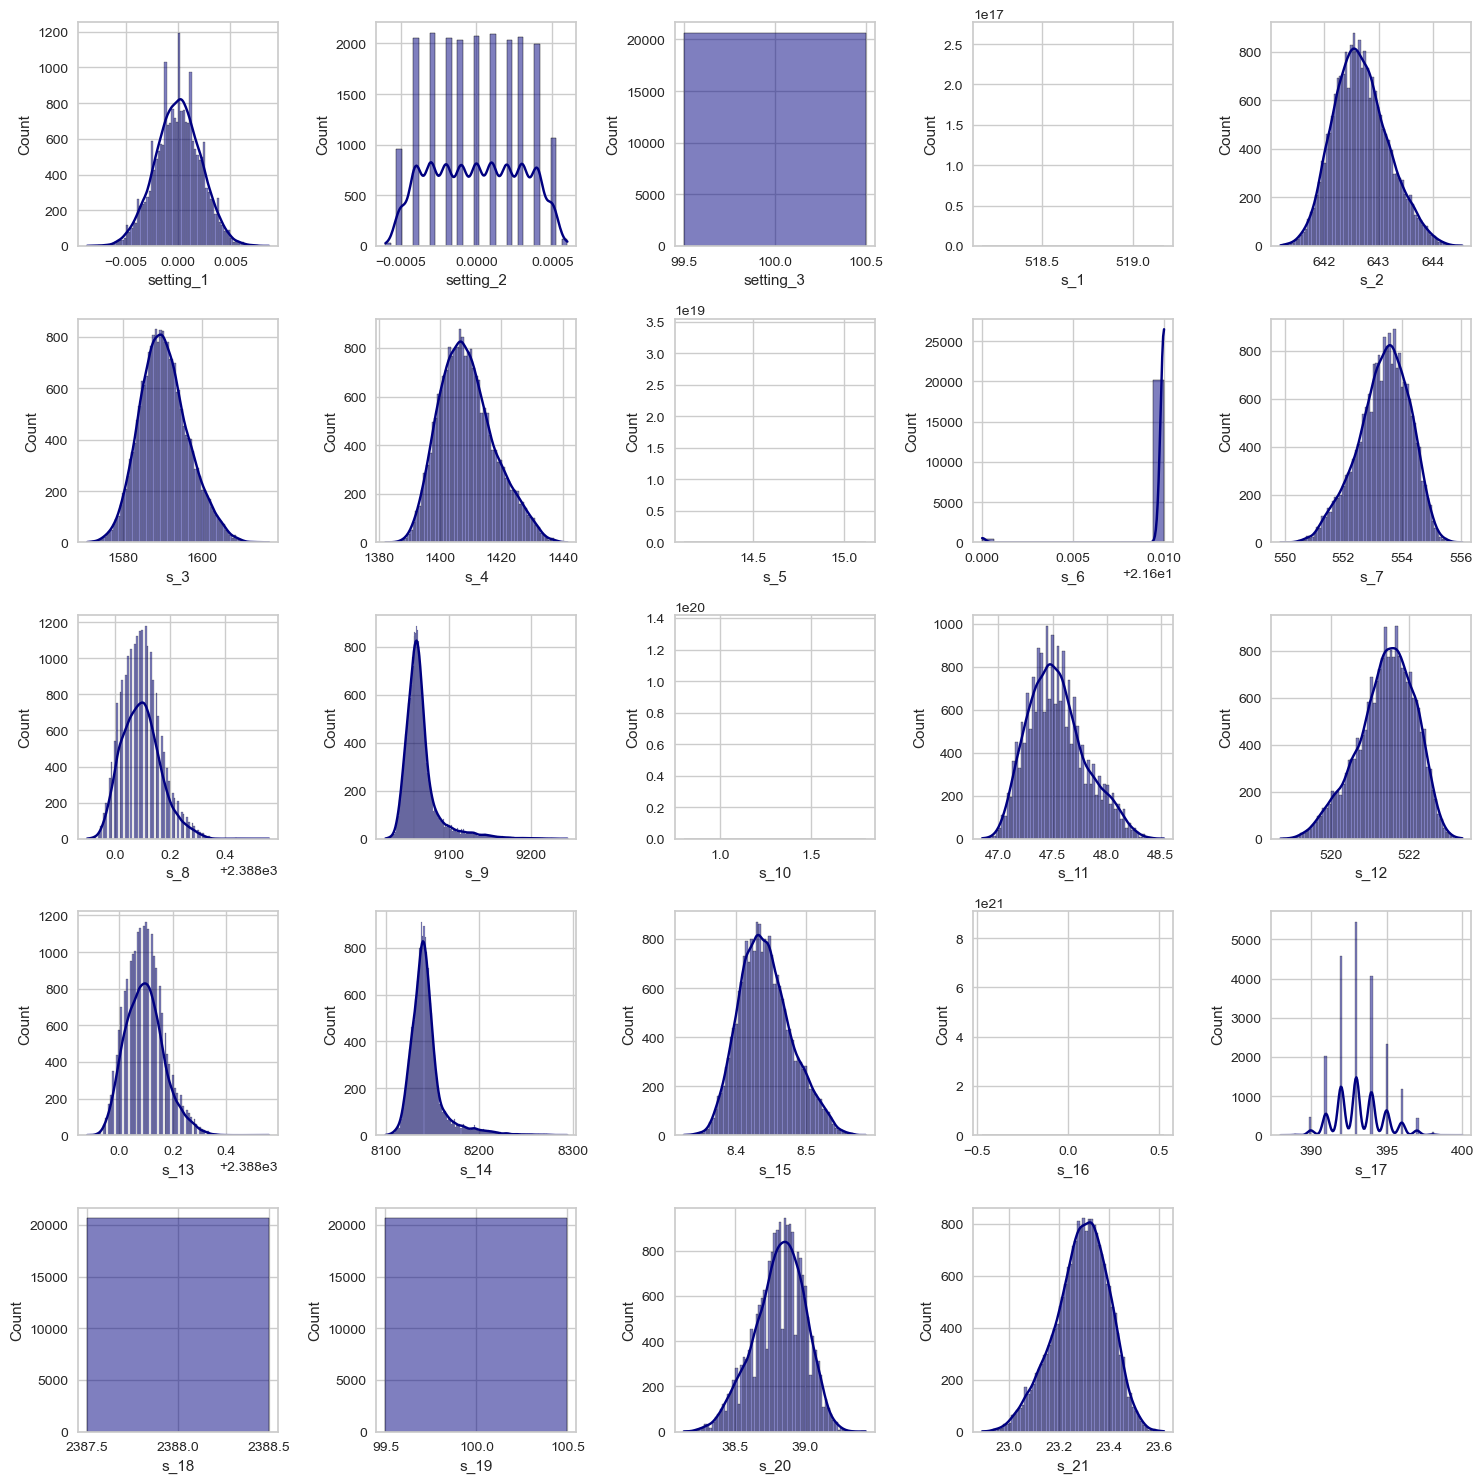

In [14]:
numeric_cols = setting_names + sensor_names

num_plots = len(numeric_cols)
total_cols = 5
total_rows = num_plots // total_cols
total_rows += 1 if num_plots % total_cols > 0 else 0  # Add an extra row if there are remaining plots

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, figsize=(3* total_cols, 3 * total_rows))

# Flatten the axs array if total_rows > 1
axs = axs.flatten() if total_rows > 1 else axs

for i, var in enumerate(numeric_cols):
    sns.histplot(data=train_df, x=var, kde=True, color="navy", ax=axs[i])

# Remove unused subplots
for i in range(num_plots, total_cols * total_rows):
    fig.delaxes(axs[i])

fig.tight_layout()


Our suspicions are confirmed and we will drop these features for our model building. Lets proceed now to split our data into train-test sets and comparing various regression models on our data

In [15]:
drop_list = ["setting_1","setting_2","setting_3","s_1","s_5","s_6","s_10","s_16","s_18","s_19"] + index_names
train_df_mod = train_df.drop(columns=drop_list)
train_df_mod.dtypes

s_2     float64
s_3     float64
s_4     float64
s_7     float64
s_8     float64
s_9     float64
s_11    float64
s_12    float64
s_13    float64
s_14    float64
s_15    float64
s_17      int64
s_20    float64
s_21    float64
RUL       int64
dtype: object

In [16]:
# importing various regression algorithms
# Linear Models
from sklearn.linear_model import LinearRegression

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# Ensemble Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor

# XGBoost
from xgboost import XGBRegressor

# LightGBM
from lightgbm import LGBMRegressor

# CatBoost
from catboost import CatBoostRegressor


In [17]:
#split training data into train and set split
X  = train_df_mod.drop(columns="RUL")
Y = train_df_mod["RUL"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

In [18]:
X_train.shape

(16504, 14)

In [19]:
y_train.shape

(16504,)

In [20]:
X_test.shape

(4127, 14)

In [21]:
y_test.shape

(4127,)

### Create a function to evaluate various algorithms

In [22]:
# Helper function
def quick_evaluate(X_train, X_test, y_train, y_test, name):
    
       
    lr = LinearRegression()
    dtr = DecisionTreeRegressor(random_state=42)
    rfr = RandomForestRegressor(random_state=42)
    gbr = GradientBoostingRegressor(random_state=42)
    abr = AdaBoostRegressor(random_state=42)
    svr = SVR(kernel='linear')
    knr = KNeighborsRegressor()
    xgr = XGBRegressor(random_state=42)
    lgbmr = LGBMRegressor(random_state=42)
    catr = CatBoostRegressor(random_state=42,verbose=0)
  

      
    regressors = [('LR', lr),('DT', dtr),
                   ('RF', rfr),('GB', gbr),('AB', abr),
                   ('SV', svr),('KN', knr),('XB', xgr),
                  ('LB', lgbmr),('CB', catr)
                 ]
    
    reg_lst = list()
    for reg_name, reg in regressors:
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        
        R2             = metrics.r2_score(y_test, y_pred)
        MAPE           = metrics.mean_absolute_percentage_error(y_test,y_pred)
        MAE            = metrics.mean_absolute_error(y_test,y_pred)
        MSE            = metrics.mean_squared_error(y_test,y_pred)
        RMSE           = np.sqrt(metrics.mean_squared_error(y_test, y_pred))        
        params         = reg.get_params()
        
        df = pd.DataFrame({
                           "Method"    : [name],
                           "Regressor" : [reg_name],
                           "R2"        : [R2],
                           #"MAPE"      : [MAPE],
                           "MAE"       : [MAE],
                           "MSE"       : [MSE],
                           "RMSE"      : [RMSE],                           
                           "Model"     : [params]
                          })
        reg_lst.append(df)
    print(reg_lst)
    dfr = pd.concat([m for m in reg_lst], axis = 0).reset_index()
    dfr = dfr.drop(columns = "index",axis =1)
    return(dfr)

In [23]:
evals = list()
evals.append(quick_evaluate(X_train, X_test, y_train, y_test,'unscaled'))

[     Method Regressor      R2        MAE         MSE       RMSE  \
0  unscaled        LR  0.5698  34.050905  1965.49563  44.333911   

                                               Model  
0  {'copy_X': True, 'fit_intercept': True, 'n_job...  ,      Method Regressor        R2        MAE          MSE       RMSE  \
0  unscaled        DT  0.233204  42.113642  3503.334383  59.188972   

                                               Model  
0  {'ccp_alpha': 0.0, 'criterion': 'squared_error...  ,      Method Regressor        R2        MAE          MSE       RMSE  \
0  unscaled        RF  0.626206  29.513181  1707.789665  41.325412   

                                               Model  
0  {'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...  ,      Method Regressor        R2        MAE          MSE       RMSE  \
0  unscaled        GB  0.625297  29.901806  1711.941049  41.375609   

                                               Model  
0  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ... 

lets try this step again, but this time with scaled features

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
sscaler = StandardScaler()
mscaler = MinMaxScaler()

X_train_s = sscaler.fit_transform(X_train)
X_test_s =  sscaler.transform(X_test)

X_train_m = mscaler.fit_transform(X_train)
X_test_m =  mscaler.transform(X_test)

In [25]:
evals.append(quick_evaluate(X_train_s, X_test_s, y_train, y_test,'Standard'))
evals.append(quick_evaluate(X_train_m, X_test_m, y_train, y_test,'MinMax'))

[     Method Regressor      R2        MAE         MSE       RMSE  \
0  Standard        LR  0.5698  34.050905  1965.49563  44.333911   

                                               Model  
0  {'copy_X': True, 'fit_intercept': True, 'n_job...  ,      Method Regressor        R2        MAE          MSE       RMSE  \
0  Standard        DT  0.230199  42.196026  3517.062515  59.304827   

                                               Model  
0  {'ccp_alpha': 0.0, 'criterion': 'squared_error...  ,      Method Regressor        R2        MAE          MSE       RMSE  \
0  Standard        RF  0.626086  29.520565  1708.336554  41.332028   

                                               Model  
0  {'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...  ,      Method Regressor        R2        MAE          MSE       RMSE  \
0  Standard        GB  0.625303  29.900432  1711.915883  41.375305   

                                               Model  
0  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ... 

In [26]:
pd.set_option('max_colwidth', 100)
evals_all = pd.concat([m for m in evals], axis = 0).reset_index()

evals_all = evals_all.drop(columns = "index",axis =1)
evals_all.sort_values(by=['R2','MAE'], ascending=False)

,Method,Regressor,R2,MAE,MSE,RMSE,Model
2,unscaled,RF,0.626206,29.513181,1707.789665,41.325412,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_feat..."
12,Standard,RF,0.626086,29.520565,1708.336554,41.332028,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_feat..."
22,MinMax,RF,0.625910,29.518054,1709.141985,41.341770,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_feat..."
13,Standard,GB,0.625303,29.900432,1711.915883,41.375305,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
3,unscaled,GB,0.625297,29.901806,1711.941049,41.375609,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
23,MinMax,GB,0.625293,29.900990,1711.958162,41.375816,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
18,Standard,LB,0.625250,29.543734,1712.157330,41.378223,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."
28,MinMax,LB,0.624344,29.719742,1716.296642,41.428211,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."
8,unscaled,LB,0.623358,29.665292,1720.798250,41.482505,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."
9,unscaled,CB,0.621970,29.686515,1727.141388,41.558891,"{'loss_function': 'RMSE', 'verbose': 0, 'random_state': 42}"
